# Model Development: NASA - Nearest Earth Objects
<img src="../assets/nasa.jpg" alt="Title-Pic">

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
warnings.filterwarnings('ignore')

# Data

In [2]:
MODEL_DATA = np.load("../model_data/nasa_prep_data.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]
input_column_names = MODEL_DATA["input_column_names"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

y_train = y_train.reshape(-1)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((40400, 4), (5050, 4), (5050, 4)), ((40400,), (5050, 1), (5050, 1)))

# Build the Model

## Helper Functions

In [ ]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [3]:
def top_rankings(cv_results, top=10):
    sorted_zipped_report = sorted(
        zip(
            cv_results["params"], 
            cv_results["mean_test_score"], 
            cv_results["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")

def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    accuracy_score_test = accuracy_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    accuracy_score_train = accuracy_score(y_train, preds_train)

    print(f"Accuracy:\t{f1_score_test}\t|\tTrain-Accuracy:\t{accuracy_score_train}")
    print(f"F1-Score:\t{accuracy_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')

def print_feature_importance(model):
    return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

## Model1: KNN Model

In [4]:
knn_tmp_model = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": np.arange(8, 12, 2),
    "metric": ["manhattan", "euclidean"],
    "weights": ["uniform", "distance"]
}

In [5]:
knn_grid_model = GridSearchCV(knn_tmp_model, knn_grid_params, cv=5, scoring="recall", verbose=3)

knn_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.983 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.985 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.985 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.980 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.979 total time=   0.1s
[CV 1/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.991 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.993 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.993 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.986 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.992 tota

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': array([ 8, 10]),
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=3)

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [6]:
knn_grid_model.best_params_, knn_grid_model.best_score_

({'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'},
 0.9925325009567196)

In [7]:
knn_grid_model.best_params_

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [8]:
knn_best_model = knn_grid_model.best_estimator_

<AxesSubplot:>

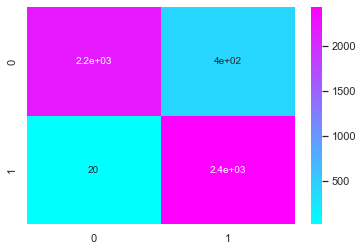

In [9]:
knn_preds = knn_best_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, knn_preds), annot=True, cmap="cool");

In [10]:
print(classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2594
           1       0.86      0.99      0.92      2456

    accuracy                           0.92      5050
   macro avg       0.93      0.92      0.92      5050
weighted avg       0.93      0.92      0.92      5050



In [11]:
knn_best_model.score(X_train, y_train), knn_best_model.score(X_test, y_test)

(1.0, 0.9172277227722773)

In [12]:
recall_score(y_train, knn_best_model.predict(X_train)), recall_score(y_test, knn_preds)

(1.0, 0.99185667752443)

## Model2: RandomForest Model

In [13]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": [90],
    "min_samples_split": [7],
    "min_samples_leaf": [6],

    # BaggingClassifier params
    "n_estimators": [700],
    "max_samples": [0.9],
    "bootstrap": [True]
}

In [14]:
rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=5, scoring="recall", verbose=3)

rf_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.982 total time=  22.5s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.983 total time=  22.3s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.981 total time=  22.0s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.975 total time=  22.5s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.975 total time=  22.2s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [90], 'max_samples': [0.9],
                         'min_samples_leaf': [6], 'min_samples_split': [7],
                         'n_estimators': [700]},
             scoring='recall', verbose=3)

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 90,
 'max_samples': 0.9,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 700}

In [15]:
rf_grid_model.best_score_

0.9792297092917341

In [16]:
rf_grid_model.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 90,
 'max_samples': 0.9,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 700}

In [17]:
rf_best_model = rf_grid_model.best_estimator_

<AxesSubplot:>

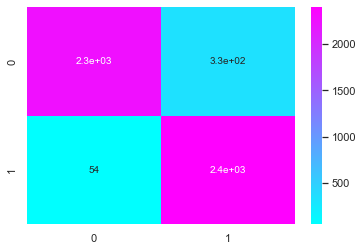

In [18]:
rf_preds = rf_best_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, cmap="cool");

In [19]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2594
           1       0.88      0.98      0.93      2456

    accuracy                           0.92      5050
   macro avg       0.93      0.93      0.92      5050
weighted avg       0.93      0.92      0.92      5050



In [20]:
rf_best_model.score(X_train, y_train), rf_best_model.score(X_test, y_test)

(0.9531188118811881, 0.9235643564356436)

In [21]:
recall_score(y_train, rf_best_model.predict(X_train)), recall_score(y_test, rf_preds)

(0.9905049206270709, 0.9780130293159609)

## Model3: SVM Model

In [22]:
svm_tmp_model = SVC()

svm_grid_params = {
    "C": [7],
    "gamma": ["auto"],
    "kernel": ["rbf"],
    "degree": [1.5],
    "coef0": [0.8]
}

In [23]:
svm_grid_model = GridSearchCV(svm_tmp_model, svm_grid_params, cv=5, scoring="recall", verbose=3)

svm_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.994 total time=  10.0s
[CV 2/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.990 total time=   9.8s
[CV 3/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.989 total time=   9.7s
[CV 4/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.990 total time=   9.8s
[CV 5/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.992 total time=   9.9s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [7], 'coef0': [0.8], 'degree': [1.5],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             scoring='recall', verbose=3)

{'C': 7, 'coef0': 0.8, 'degree': 1.5, 'gamma': 'auto', 'kernel': 'rbf'}

In [24]:
svm_grid_model.best_score_

0.9908510586270433

In [25]:
svm_grid_model.best_params_

{'C': 7, 'coef0': 0.8, 'degree': 1.5, 'gamma': 'auto', 'kernel': 'rbf'}

In [26]:
svm_best_model = svm_grid_model.best_estimator_

<AxesSubplot:>

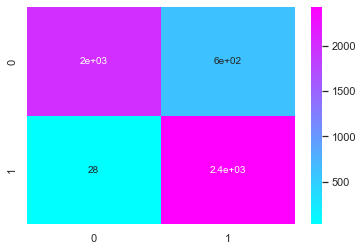

In [27]:
svm_preds = svm_best_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, cmap="cool");

In [28]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      2594
           1       0.80      0.99      0.88      2456

    accuracy                           0.87      5050
   macro avg       0.89      0.88      0.87      5050
weighted avg       0.90      0.87      0.87      5050



In [29]:
svm_best_model.score(X_train, y_train), svm_best_model.score(X_test, y_test)

(0.8794554455445545, 0.8746534653465347)

In [30]:
recall_score(y_train, svm_best_model.predict(X_train)), recall_score(y_test, svm_preds)

(0.9908510953958756, 0.988599348534202)

## Model4: GradientBoost Model

In [31]:
xgb_tmp_model = XGBClassifier(nthread=-1,)

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "learning_rate": [0.005],
    "min_child_weight": [7],
    "n_estimators": [700],
    "eta": [0.05],
    "gamma": [4],
    "subsample": [0.55],
    "max_depth": [10],
    "colsample_bytree": [0.65]
}

In [32]:
xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=5, scoring="recall", verbose=3)

xgb_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.997 total time=   7.5s
[CV 2/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.992 total time=   7.2s
[CV 3/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.992 total time=   7.2s
[CV 4/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.990 total time=   7.3s
[CV 5/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subs

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bytree': [0.65], 'eta': [0.05],
                         'eval_metric': ['logloss'], 'gamma': [4],
                         'learning_rate': [0.005], 'max_depth': [10],
                         'min_child_weight': [7], 'n_estimators': [700],
                         'subsample': [0.55]},
             scoring='recall', verbose=3)

{'colsample_bytree': 0.65,
 'eta': 0.05,
 'eval_metric': 'logloss',
 'gamma': 4,
 'learning_rate': 0.005,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 700,
 'subsample': 0.55}

In [33]:
xgb_grid_model.best_score_

0.9921863824261921

In [34]:
xgb_grid_model.best_params_

{'colsample_bytree': 0.65,
 'eta': 0.05,
 'eval_metric': 'logloss',
 'gamma': 4,
 'learning_rate': 0.005,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 700,
 'subsample': 0.55}

In [35]:
xgb_best_model = xgb_grid_model.best_estimator_

<AxesSubplot:>

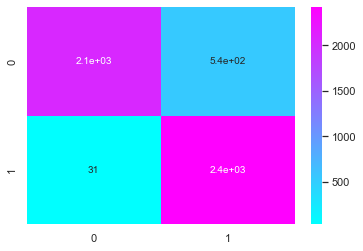

In [36]:
xgb_preds = xgb_best_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, cmap="cool");

In [37]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      2594
           1       0.82      0.99      0.89      2456

    accuracy                           0.89      5050
   macro avg       0.90      0.89      0.89      5050
weighted avg       0.90      0.89      0.89      5050



In [38]:
xgb_best_model.score(X_train, y_train), xgb_best_model.score(X_test, y_test)

(0.8998762376237623, 0.8873267326732673)

In [39]:
recall_score(y_train, xgb_best_model.predict(X_train)), recall_score(y_test, xgb_preds)

(0.9943622966223233, 0.9873778501628665)

## Model5-7: Ensemble Model

#### Model5: Best Recall-Ensemble-Model

In [40]:
recall_models = Series(
    data=[
        recall_score(y_test, knn_best_model.predict(X_test)),
        recall_score(y_test, rf_best_model.predict(X_test)),
        recall_score(y_test, svm_best_model.predict(X_test)),
        recall_score(y_test, xgb_best_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost"]
)

recall_models.sort_values(ascending=False)

KNN             0.991857
SVM             0.988599
XGBoost         0.987378
RandomForest    0.978013
dtype: float64

In [41]:
knn_model_tuple = ("knn_best_model", knn_best_model)
xgb_model_tuple = ("xgb_best_model", xgb_best_model)
svm_model_tuple = ("svm_best_model", svm_best_model)
rf_model_tuple = ("rf_best_model", rf_best_model)

model_combo_1 = [knn_model_tuple, xgb_model_tuple, svm_model_tuple]
model_combo_2 = [knn_model_tuple, xgb_model_tuple, svm_model_tuple, rf_model_tuple]
model_combo_3 = [knn_model_tuple, xgb_model_tuple, rf_model_tuple]

ensemble_recall_model_1 = VotingClassifier(estimators=model_combo_1)
ensemble_recall_model_2 = VotingClassifier(estimators=model_combo_2)
test_best_model = VotingClassifier(estimators=model_combo_3)

In [42]:
ensemble_recall_model_1.fit(X_train, y_train)
ensemble_recall_model_2.fit(X_train, y_train)
test_best_model.fit(X_train, y_train);

VotingClassifier(estimators=[('knn_best_model',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=10,
                                                   weights='distance')),
                             ('xgb_best_model',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.65,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.05,
                                            eval_metric='logloss', gamm...
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.005, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=0, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=700, n_jobs=-1,
                                            nthread=-1, num_parallel_tree=1,
                                            predictor='auto', random_state=0, ...)),
                             ('svm_best_model',
                              SVC(C=7, coef0=0.8, degree=1.5, gamma='auto'))])

In [45]:
(recall_score(y_test, ensemble_recall_model_1.predict(X_test)) + f1_score(y_test, ensemble_recall_model_1.predict(X_test))) / 2

0.9457748592556454

In [46]:
(recall_score(y_test, ensemble_recall_model_2.predict(X_test)) + f1_score(y_test, ensemble_recall_model_2.predict(X_test))) / 2

0.9526723380390474

In [47]:
(recall_score(y_test, test_best_model.predict(X_test)) + f1_score(y_test, test_best_model.predict(X_test))) / 2

0.9531573603047951

In [48]:
ensemble_best_recall_model = ensemble_recall_model_1

In [49]:
recall_models = Series(
    data=[
        recall_score(y_test, knn_best_model.predict(X_test)),
        recall_score(y_test, rf_best_model.predict(X_test)),
        recall_score(y_test, svm_best_model.predict(X_test)),
        recall_score(y_test, xgb_best_model.predict(X_test)),
        recall_score(y_test, ensemble_best_recall_model.predict(X_test)),
        recall_score(y_test, test_best_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Ensemble_KNN_XGB_SVM", "Ensemble_KNN_XGB_RF"]
)

recall_models.sort_values(ascending=False)

Ensemble_KNN_XGB_SVM    0.994707
KNN                     0.991857
Ensemble_KNN_XGB_RF     0.989821
SVM                     0.988599
XGBoost                 0.987378
RandomForest            0.978013
dtype: float64

In [50]:
best_recall_model = ensemble_best_recall_model

#### Model5: Best Accuracy-Ensemble-Model

In [51]:
accuracy_models = Series(
    data=[
        f1_score(y_test, knn_best_model.predict(X_test)),
        f1_score(y_test, rf_best_model.predict(X_test)),
        f1_score(y_test, svm_best_model.predict(X_test)),
        f1_score(y_test, xgb_best_model.predict(X_test)),
        f1_score(y_test, test_best_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Ensemble_KNN_XGB_RF"]
)

accuracy_models.sort_values(ascending=False)

RandomForest           0.925626
KNN                    0.920983
Ensemble_KNN_XGB_RF    0.916494
XGBoost                0.894999
SVM                    0.884678
dtype: float64

In [52]:
knn_model_tuple = ("knn_best_model", knn_best_model)
xgb_model_tuple = ("xgb_best_model", xgb_best_model)
svm_model_tuple = ("svm_best_model", svm_best_model)
rf_model_tuple = ("rf_best_model", rf_best_model)

model_combo_1 = [rf_model_tuple, knn_model_tuple, xgb_model_tuple]
model_combo_2 = [rf_model_tuple, knn_model_tuple, xgb_model_tuple, svm_model_tuple]

ensemble_accuracy_model_1 = VotingClassifier(estimators=model_combo_1)
ensemble_accuracy_model_2 = VotingClassifier(estimators=model_combo_2)

In [53]:
ensemble_accuracy_model_1.fit(X_train, y_train)
ensemble_accuracy_model_2.fit(X_train, y_train);

VotingClassifier(estimators=[('rf_best_model',
                              RandomForestClassifier(max_depth=90,
                                                     max_samples=0.9,
                                                     min_samples_leaf=6,
                                                     min_samples_split=7,
                                                     n_estimators=700)),
                             ('knn_best_model',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=10,
                                                   weights='distance')),
                             ('xgb_best_model',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            c...
                                            eval_metric='logloss', gamma=4,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.005, max_bin=256,
                                            max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=0, min_child_weight=7,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=700, n_jobs=-1,
                                            nthread=-1, num_parallel_tree=1,
                                            predictor='auto', random_state=0, ...))])

In [55]:
f1_score(y_test, ensemble_accuracy_model_1.predict(X_test)), f1_score(y_test, ensemble_accuracy_model_2.predict(X_test))

0.9168081494057725

In [57]:
ensemble_best_accuracy_model = ensemble_accuracy_model_2

In [58]:
accuracy_models = Series(
    data=[
        f1_score(y_test, knn_best_model.predict(X_test)),
        f1_score(y_test, rf_best_model.predict(X_test)),
        f1_score(y_test, svm_best_model.predict(X_test)),
        f1_score(y_test, xgb_best_model.predict(X_test)),
        f1_score(y_test, ensemble_best_accuracy_model.predict(X_test)),
        f1_score(y_test, test_best_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Ensemble_RF_KNN_XGB_SVM", "Ensemble_KNN_XGB_RF"]
)

accuracy_models.sort_values(ascending=False)

RandomForest               0.925626
KNN                        0.920983
Ensemble_RF_KNN_XGB_SVM    0.916856
Ensemble_KNN_XGB_RF        0.916494
XGBoost                    0.894999
SVM                        0.884678
dtype: float64

In [59]:
best_accuracy_model = rf_best_model

# Final Model Selection

#### Validate Models

In [60]:
recall_models = Series(
    data=[
        recall_score(y_val, knn_best_model.predict(X_val)),
        recall_score(y_val, rf_best_model.predict(X_val)),
        recall_score(y_val, svm_best_model.predict(X_val)),
        recall_score(y_val, xgb_best_model.predict(X_val)),
        recall_score(y_val, best_recall_model.predict(X_val)),
        recall_score(y_val, test_best_model.predict(X_val)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Best_Recall_Model", "Ensemble_KNN_XGB_RF"]
)

recall_models.sort_values(ascending=False)

Best_Recall_Model      0.996891
KNN                    0.994559
Ensemble_KNN_XGB_RF    0.994170
XGBoost                0.992616
SVM                    0.991450
RandomForest           0.980956
dtype: float64

In [61]:
accuracy_models = Series(
    data=[
        f1_score(y_val, knn_best_model.predict(X_val)),
        f1_score(y_val, rf_best_model.predict(X_val)),
        f1_score(y_val, svm_best_model.predict(X_val)),
        f1_score(y_val, xgb_best_model.predict(X_val)),
        f1_score(y_val, best_recall_model.predict(X_val)),
        f1_score(y_val, test_best_model.predict(X_val)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Best_Recall_Model", "Ensemble_KNN_XGB_RF"]
)

accuracy_models.sort_values(ascending=False)

RandomForest           0.933605
KNN                    0.931731
Ensemble_KNN_XGB_RF    0.930182
XGBoost                0.914265
Best_Recall_Model      0.912487
SVM                    0.901413
dtype: float64

In [62]:
print("Ensemble_KNN_XGB_RF", classification_report(y_val, test_best_model.predict(X_val)))
print("best_recall_model", classification_report(y_val, best_recall_model.predict(X_val)))
print("KNN", classification_report(y_val, knn_best_model.predict(X_val)))
print("RandomForest", classification_report(y_val, rf_best_model.predict(X_val)))

Ensemble_KNN_XGB_RF               precision    recall  f1-score   support

           0       0.99      0.85      0.92      2477
           1       0.87      0.99      0.93      2573

    accuracy                           0.92      5050
   macro avg       0.93      0.92      0.92      5050
weighted avg       0.93      0.92      0.92      5050

best_recall_model               precision    recall  f1-score   support

           0       1.00      0.80      0.89      2477
           1       0.84      1.00      0.91      2573

    accuracy                           0.90      5050
   macro avg       0.92      0.90      0.90      5050
weighted avg       0.92      0.90      0.90      5050

KNN               precision    recall  f1-score   support

           0       0.99      0.85      0.92      2477
           1       0.88      0.99      0.93      2573

    accuracy                           0.93      5050
   macro avg       0.93      0.92      0.93      5050
weighted avg       0.93      0.9

In [63]:
CHOSEN_BEST_MODEL = knn_best_model
MODEL_PREDICTIONS = CHOSEN_BEST_MODEL.predict(X_val)
MODEL_REPORT = classification_report(y_val, MODEL_PREDICTIONS)
RECALL_SCORE = f"{np.round(recall_score(y_val, MODEL_PREDICTIONS) * 100, 3)}%"
F1_SCORE = f"{np.round(f1_score(y_val, MODEL_PREDICTIONS) * 100, 3)}%"

print("REPORT:", MODEL_REPORT)
print("RECALL_SCORE:\t", RECALL_SCORE)
print("F1_SCORE:\t", F1_SCORE)

REPORT:               precision    recall  f1-score   support

           0       0.99      0.85      0.92      2477
           1       0.88      0.99      0.93      2573

    accuracy                           0.93      5050
   macro avg       0.93      0.92      0.93      5050
weighted avg       0.93      0.93      0.93      5050

RECALL_SCORE:	 99.456%
F1_SCORE:	 93.173%


# Export the Model

## Export

In [69]:
import pickle
from datetime import datetime
timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")

with open(f"../trained_models/{timestamp_string}_knn_best_model", "wb") as model_file:
    pickle.dump(CHOSEN_BEST_MODEL, model_file)

## Test Import

In [70]:
with open(f"../trained_models/{timestamp_string}_knn_best_model", "rb") as model_file:
    my_imported_model = pickle.load(model_file)

print(classification_report(y_val, my_imported_model.predict(X_val)))

KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')

# Test Model-Export in Class

In [72]:
class ModelWrapper:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
    
    def predict(self, values):
        prep_values = self.preprocess_values(values)
        pass

    def preprocess_values(self, values):
        pass

my_wrapper_model = ModelWrapper(my_imported_model, None)
timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")

with open(f"../trained_models/{timestamp_string}_wrapper_model_best_model", "wb") as model_file:
    pickle.dump(my_wrapper_model, model_file)

In [73]:
with open(f"../trained_models/{timestamp_string}_wrapper_model_best_model", "rb") as model_file:
    my_imported_wrapper_model = pickle.load(model_file)

print(my_imported_wrapper_model.model)

KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')